# Snow Cover Extent bias LS3MIP IPSL
conda env: `phd_v3` (in `envs/phd`)

Try to compare the **snow cover** for the **CMIP6 historical** experiments: **coupled** + **land-hist**
- Zone: **NH** (try to see other mountainous areas)
- Period: **1999-2012** (obs with better resolution but shorter period)
- Models: **IPSL-CMA6-LR**
- Observation: **MEaSUREs** Northern Hemisphere Terrestrial Snow Cover Extent Daily 25km EASE-Grid 2.0, Version 1: https://nsidc.org/data/nsidc-0530 (satellite)

Created: 16/09/2020 - Last modified: 16/09/2020

## Import modules

In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
plot.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
sys.path.insert(1, '/home/mlalande/notebooks/utils') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
# u.check_virtual_memory()

3.8.5 | packaged by conda-forge | (default, Jul 24 2020, 01:25:15) 
[GCC 7.5.0]


## Set variables

In [2]:
period = slice('1999','2012')
seasons = ['Annual', 'DJF', 'JJA']

var = 'snc'
table = u.get_table(var)
label, units, cmap, levels = u.get_var_infos(var)
label

'Snow Cover Extent'

## Load model

In [3]:
# list_models = u.get_model_names()
list_models = ['IPSL-CM6A-LR']

for i, model in enumerate(list_models):
    print(model + ' ('+str(i+1)+'/'+str(len(list_models))+')')
    institute, grid, realization, calendar = u.get_model_infos(model, var)
    print(institute, grid, realization, calendar)

IPSL-CM6A-LR (1/1)
IPSL gr r1i1p1f1 gregorian


In [4]:
def check_snc(da):
    # Some models have values between 0 and 1 even if units in %    
    if da.max().values <= 1.1:
        with xr.set_options(keep_attrs=True):
            da = da*100
        da.attrs['units'] = '%'

    # Some models have wrong values (+-0.1 for numeric precision)
    da = da.where( (da >= -0.1) & (da <= 100.1) )

In [5]:
# Load historical
da_historical = xr.open_mfdataset(
    '/bdd/CMIP6/CMIP/'+institute+'/'+model+'/historical/'+realization+'/'+table+'/'+var+'/'+grid+'/latest/*.nc', 
    combine='by_coords'
).sel(time=period)[var].chunk({'time': -1, 'lon': -1, 'lat': -1})

# Load land-hist
da_land_hist = xr.open_mfdataset(
    '/bdd/CMIP6/LS3MIP/'+institute+'/'+model+'/land-hist/'+realization+'/'+table+'/'+var+'/'+grid+'/latest/*.nc', 
    combine='by_coords'
).sel(time=period)[var].chunk({'time': -1, 'lon': -1, 'lat': -1})

# Check if the time steps are ok
np.testing.assert_equal((int(period.stop) - int(period.start) + 1)*12, da_historical.time.size)
np.testing.assert_equal((int(period.stop) - int(period.start) + 1)*12, da_land_hist.time.size)

# snc (0-1 to % when needed and take out wrong values)
check_snc(da_historical)
check_snc(da_land_hist)

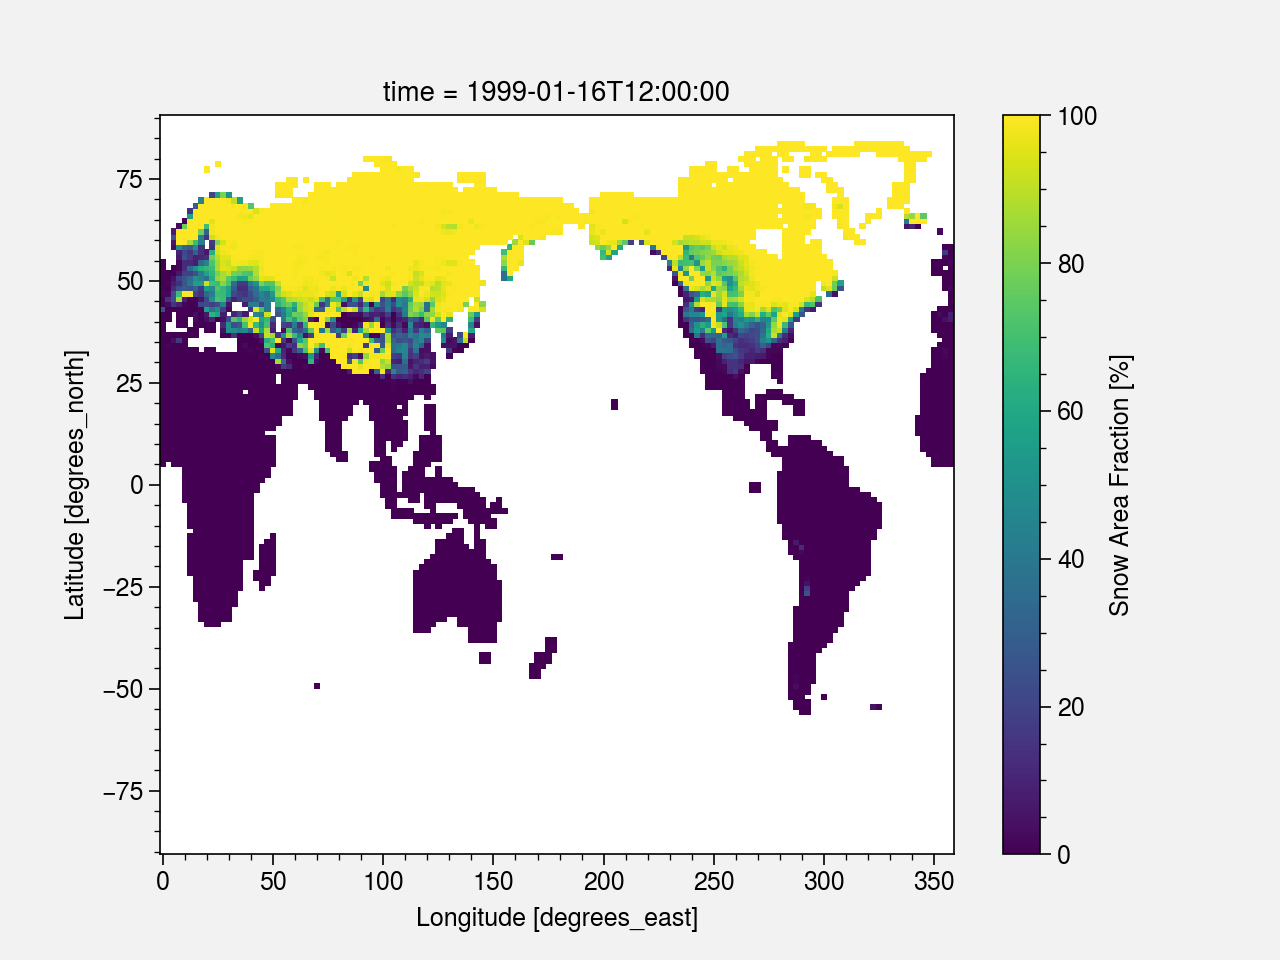

In [6]:
da_historical.isel(time=0).plot()

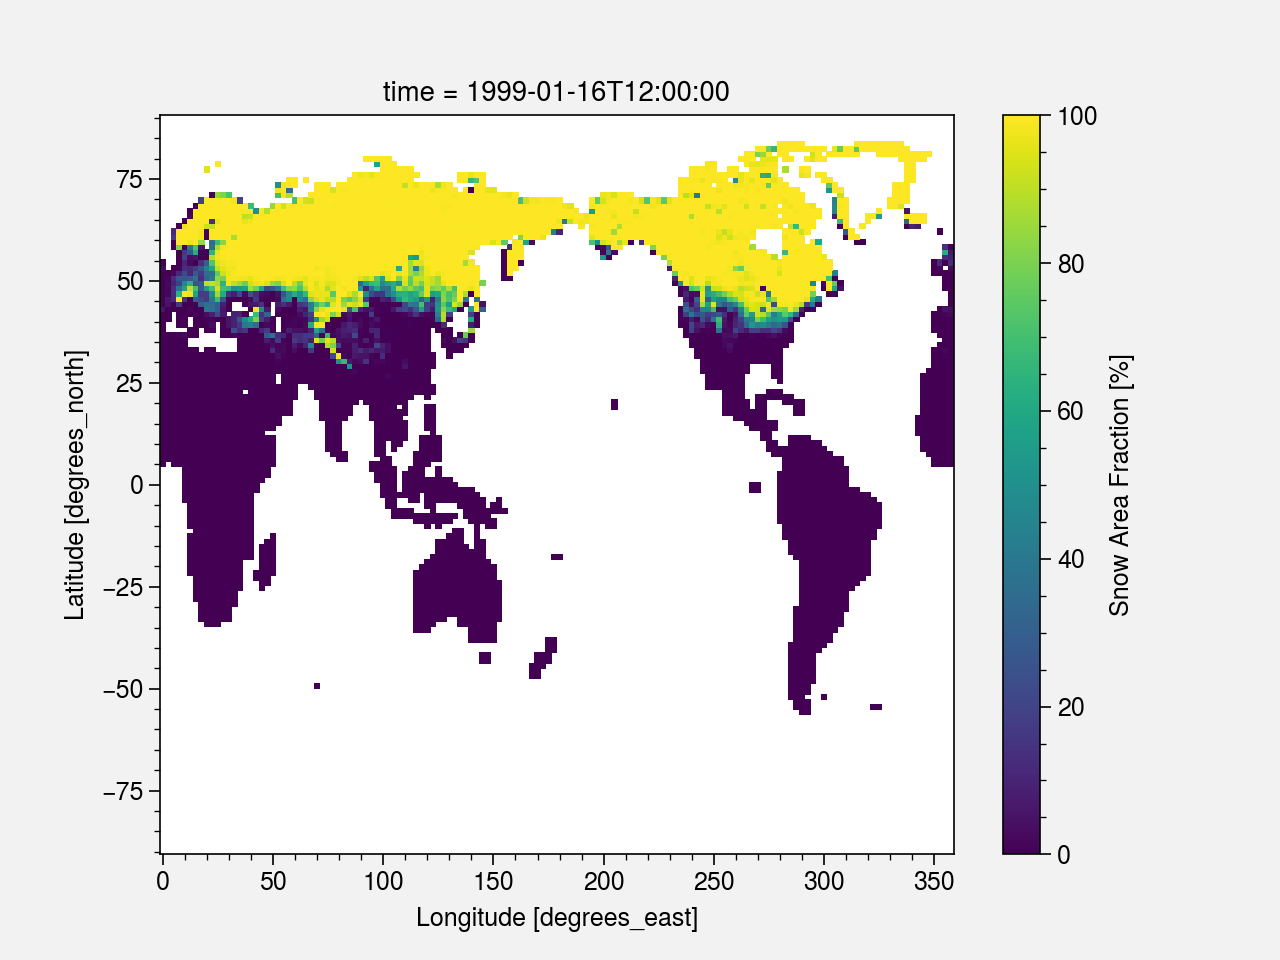

In [7]:
da_land_hist.isel(time=0).plot()

## Load observation
**MEaSUREs** Northern Hemisphere Terrestrial Snow Cover Extent Daily 25km EASE-Grid 2.0, Version 1: https://nsidc.org/data/nsidc-0530 

*This data set, part of the NASA Making Earth System Data Records for Use in Research Environments (MEaSUREs) program, offers users **25 km Northern Hemisphere** snow cover extent represented by four different variables. Three of the snow cover variables are derived from the Interactive Multisensor Snow and Ice Mapping System, MODIS Cloud Gap Filled Snow Cover, and passive microwave brightness temperatures, respectively. The fourth variable merges the three source products into a single representation of snow cover.*

Other observations: https://globalcryospherewatch.org/reference/snow_inventory.php

In [8]:
obs = xr.open_mfdataset(
    '/data/mlalande/MEaSUREs/monthly/nhtsd25e2_*_v01r01.nc', combine='by_coords'
).merged_snow_cover_extent.sel(time=period).load() * 100
obs = obs.rename({'longitude': 'lon', 'latitude': 'lat'})
obs.attrs['units'] = '%'
obs.attrs['long_name'] = 'MEaSUREs Northern Hemisphere Terrestrial Snow Cover Extent Daily 25km EASE-Grid 2.0, Version 1'
obs.attrs['short_name'] = 'MEaSUREs'

# Check if the time steps are ok
np.testing.assert_equal((int(period.stop) - int(period.start) + 1)*12, obs.time.size)

In [9]:
# obs

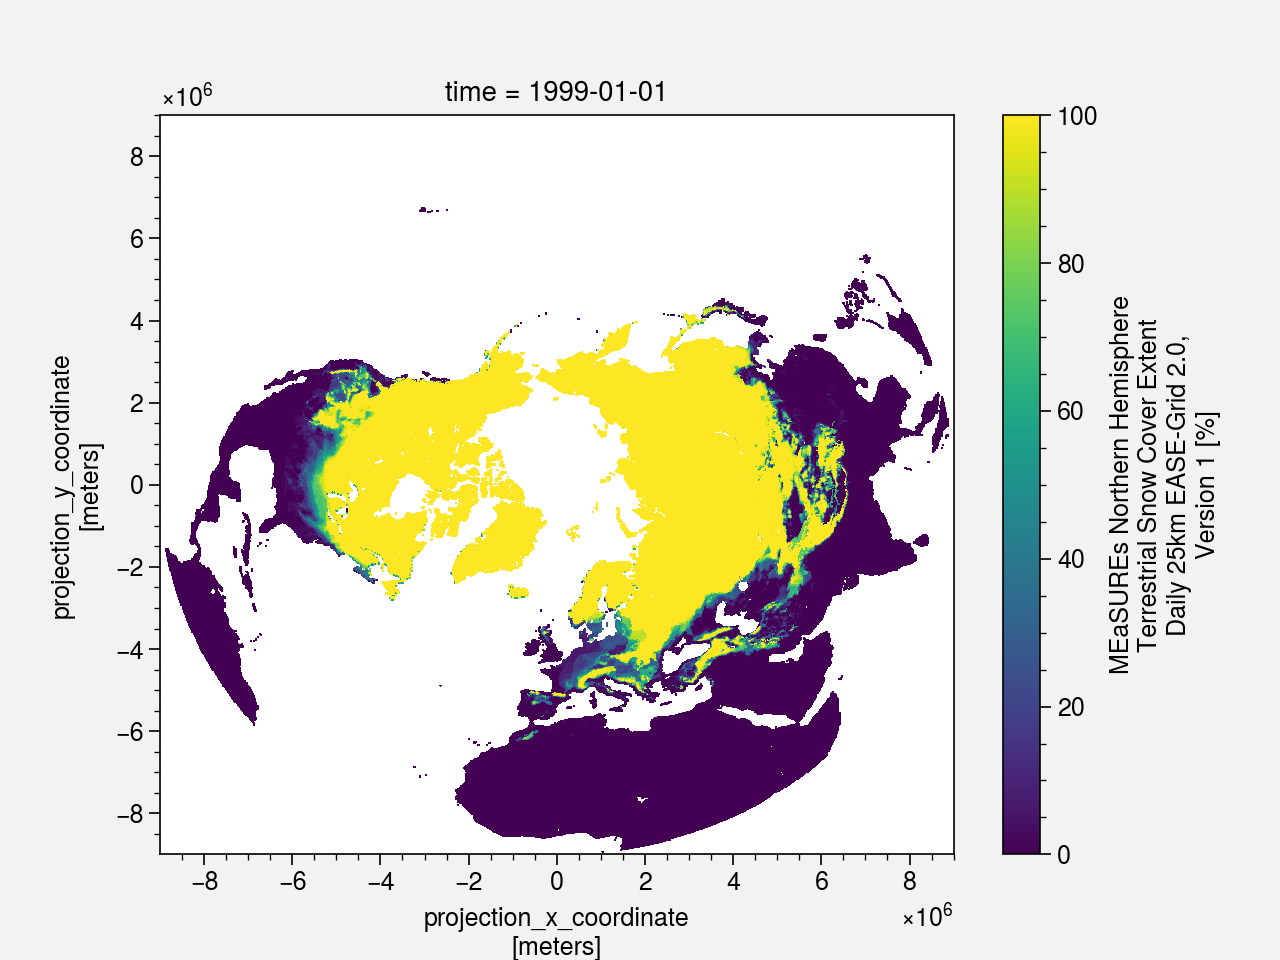

In [10]:
obs.isel(time=0).plot()

## Regrid observation to the model grid
Using xESMF (https://xesmf.readthedocs.io/en/latest/)

In [11]:
# To put NaNs instead of 0 where there is no data (https://github.com/JiaweiZhuang/xESMF/issues/15)
import scipy
def add_matrix_NaNs(regridder):
        X = regridder.weights
        M = scipy.sparse.csr_matrix(X)
        num_nonzeros = np.diff(M.indptr)
        M[num_nonzeros == 0, 0] = np.NaN
        regridder.weights = scipy.sparse.coo_matrix(M)
        return regridder


regridder = xe.Regridder(obs, da_historical, 'bilinear', periodic=False, reuse_weights=True)
regridder = add_matrix_NaNs(regridder)
obs_regrid = regridder(obs)

Reuse existing file: bilinear_720x720_143x144.nc


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


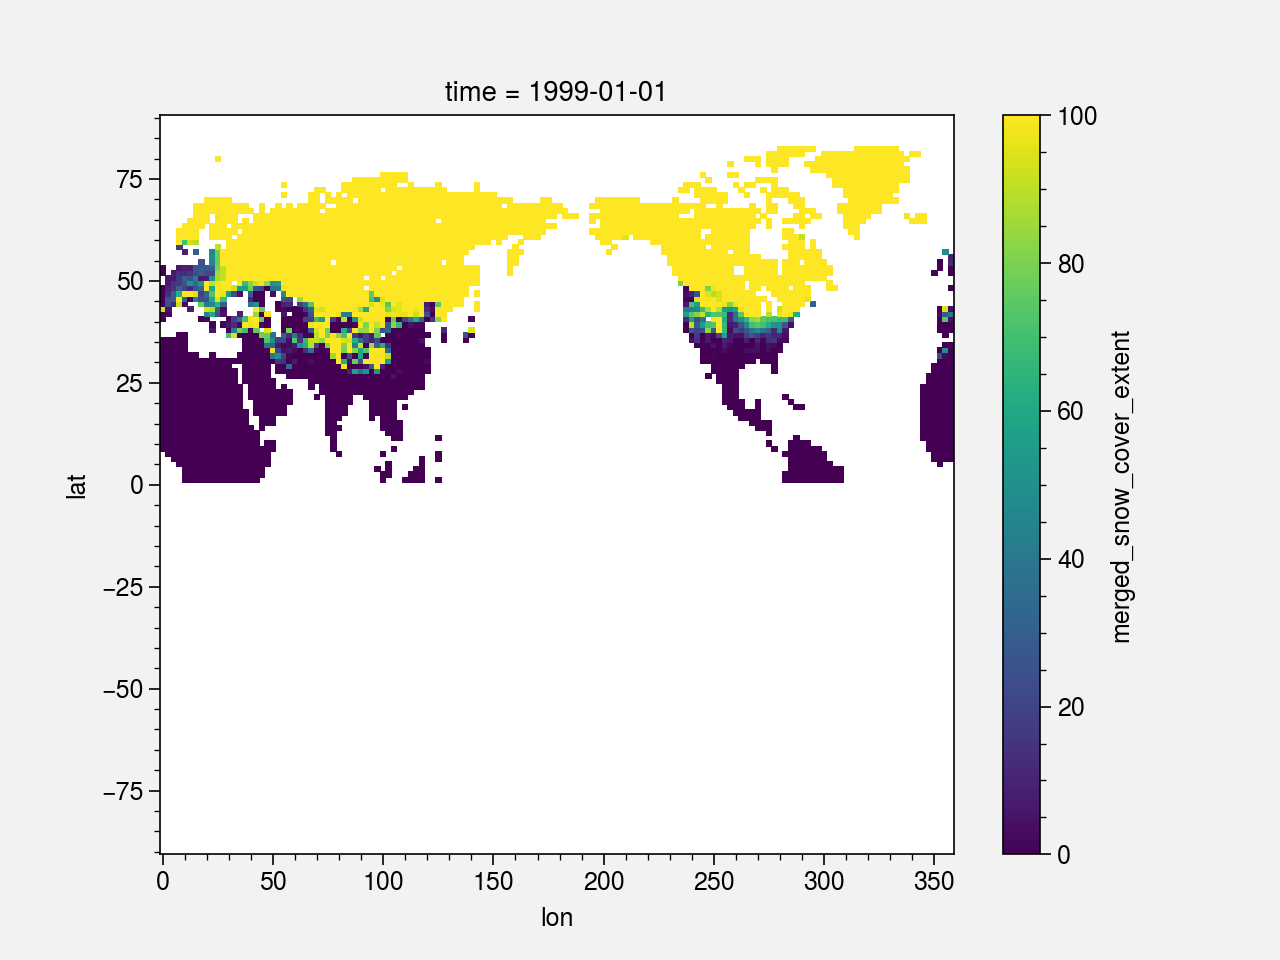

In [12]:
obs_regrid.isel(time=0).plot()

## Compare plots

### First time step

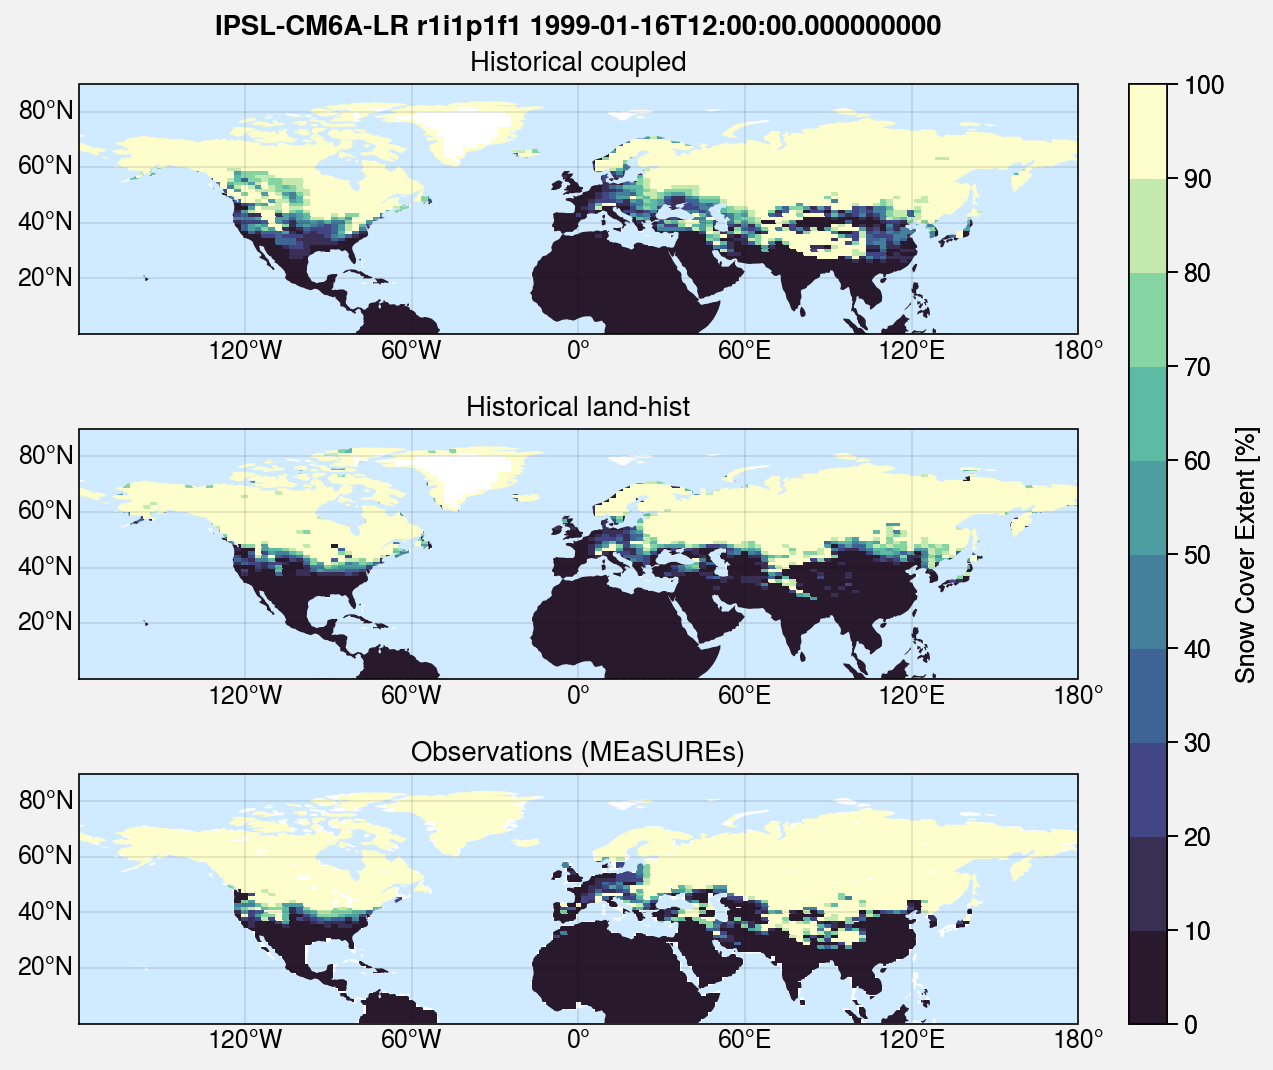

In [13]:
fig, axs = plot.subplots(nrows=3, ncols=1, proj='cyl', axwidth=5)

cmap='deep_r'
levels=plot.arange(0,100,10)
itime=0

axs.format(
    labels=True,
    latlim=(0,90),
    ocean=True, oceancolor='blue1',
    coast=False,
    suptitle=model+' '+realization+' '+str(da_historical.isel(time=itime).time.values)
)

axs[0].pcolormesh(da_historical.isel(time=itime), cmap=cmap, levels=levels)
axs[0].format(title='Historical coupled')

axs[1].pcolormesh(da_land_hist.isel(time=itime), cmap=cmap, levels=levels)
axs[1].format(title='Historical land-hist')

m = axs[2].pcolormesh(obs_regrid.isel(time=itime), cmap=cmap, levels=levels)
axs[2].format(title='Observations ('+obs.short_name+')')

fig.colorbar(m, label=label+' ['+units+']')

### Climatology

In [14]:
clim_historical = [None]*len(seasons)
clim_land_hist = [None]*len(seasons)
clim_obs_regrid = [None]*len(seasons)

for i, season in enumerate(seasons):
    clim_historical[i] = u.clim(da_historical, season=season, calendar=calendar)
    clim_land_hist[i] = u.clim(da_land_hist, season=season, calendar=calendar)
    clim_obs_regrid[i] = u.clim(obs_regrid, season=season, calendar=calendar)

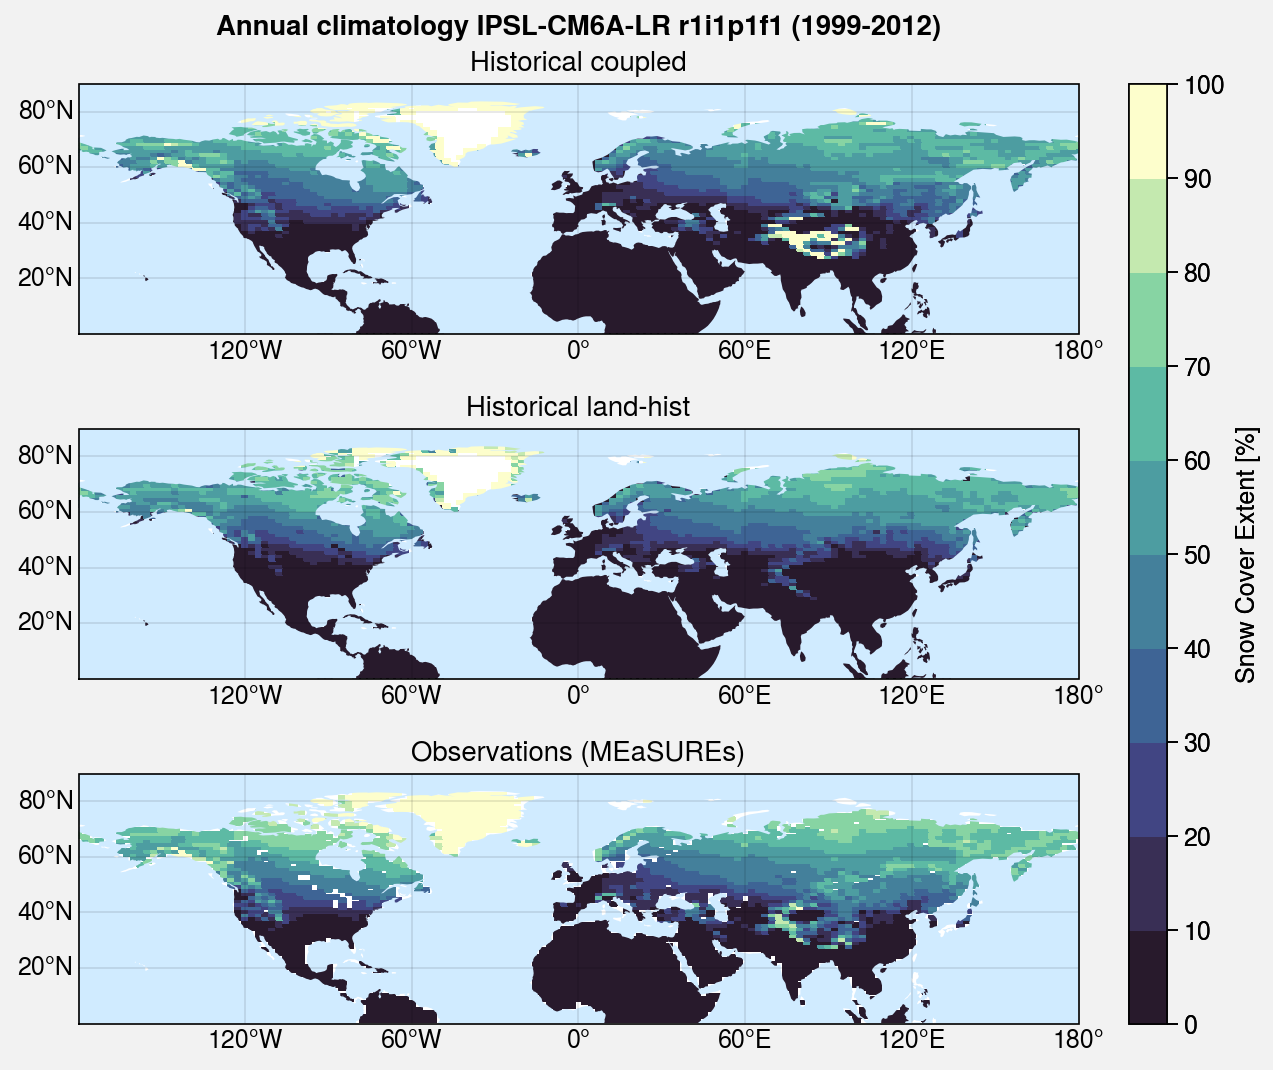

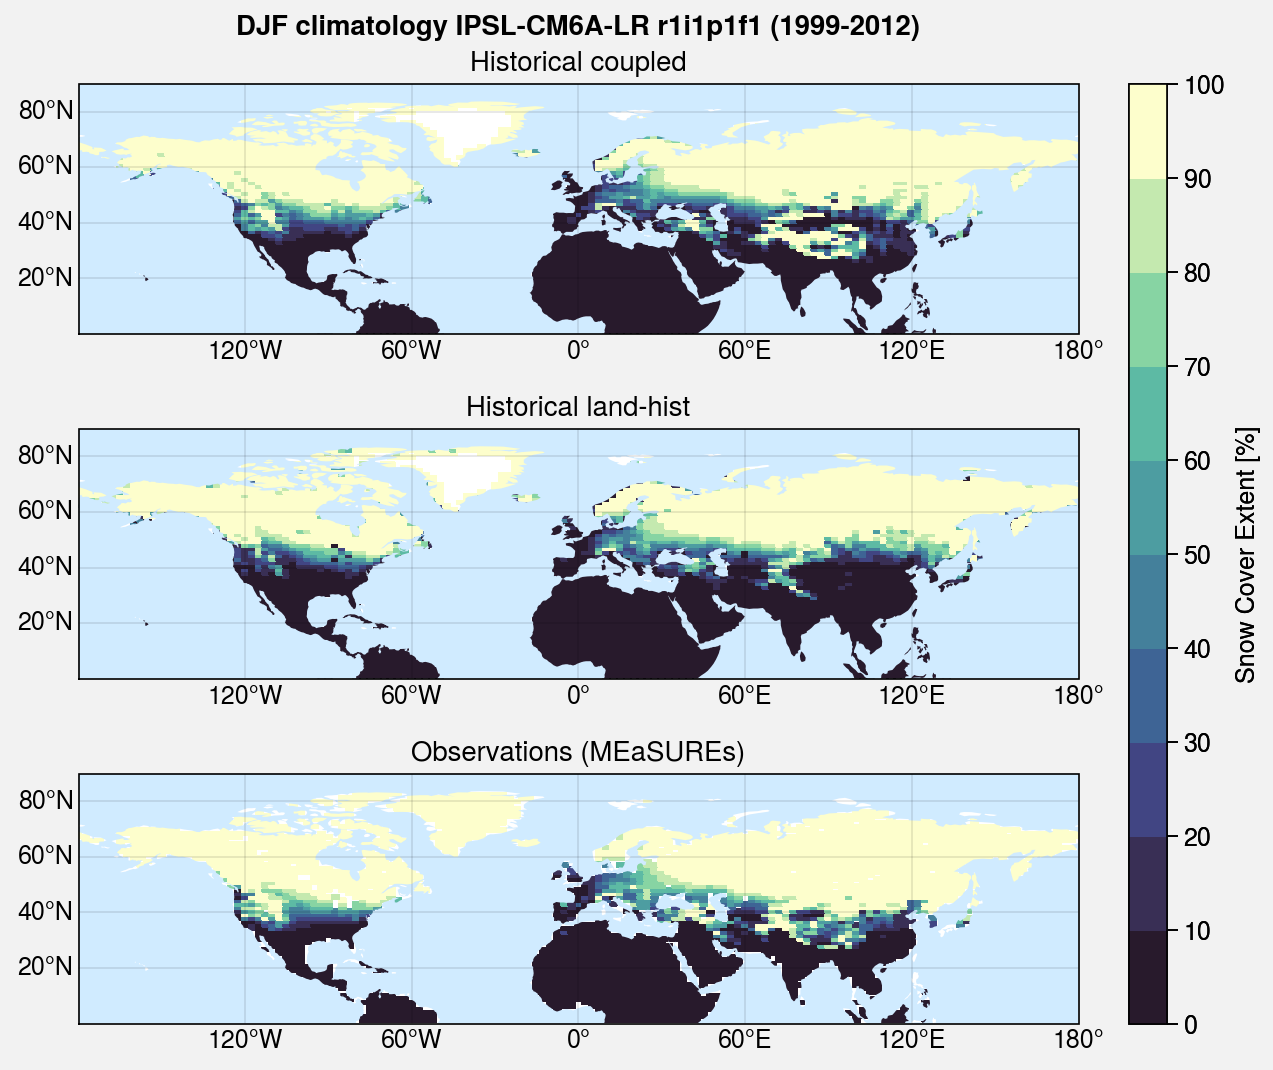

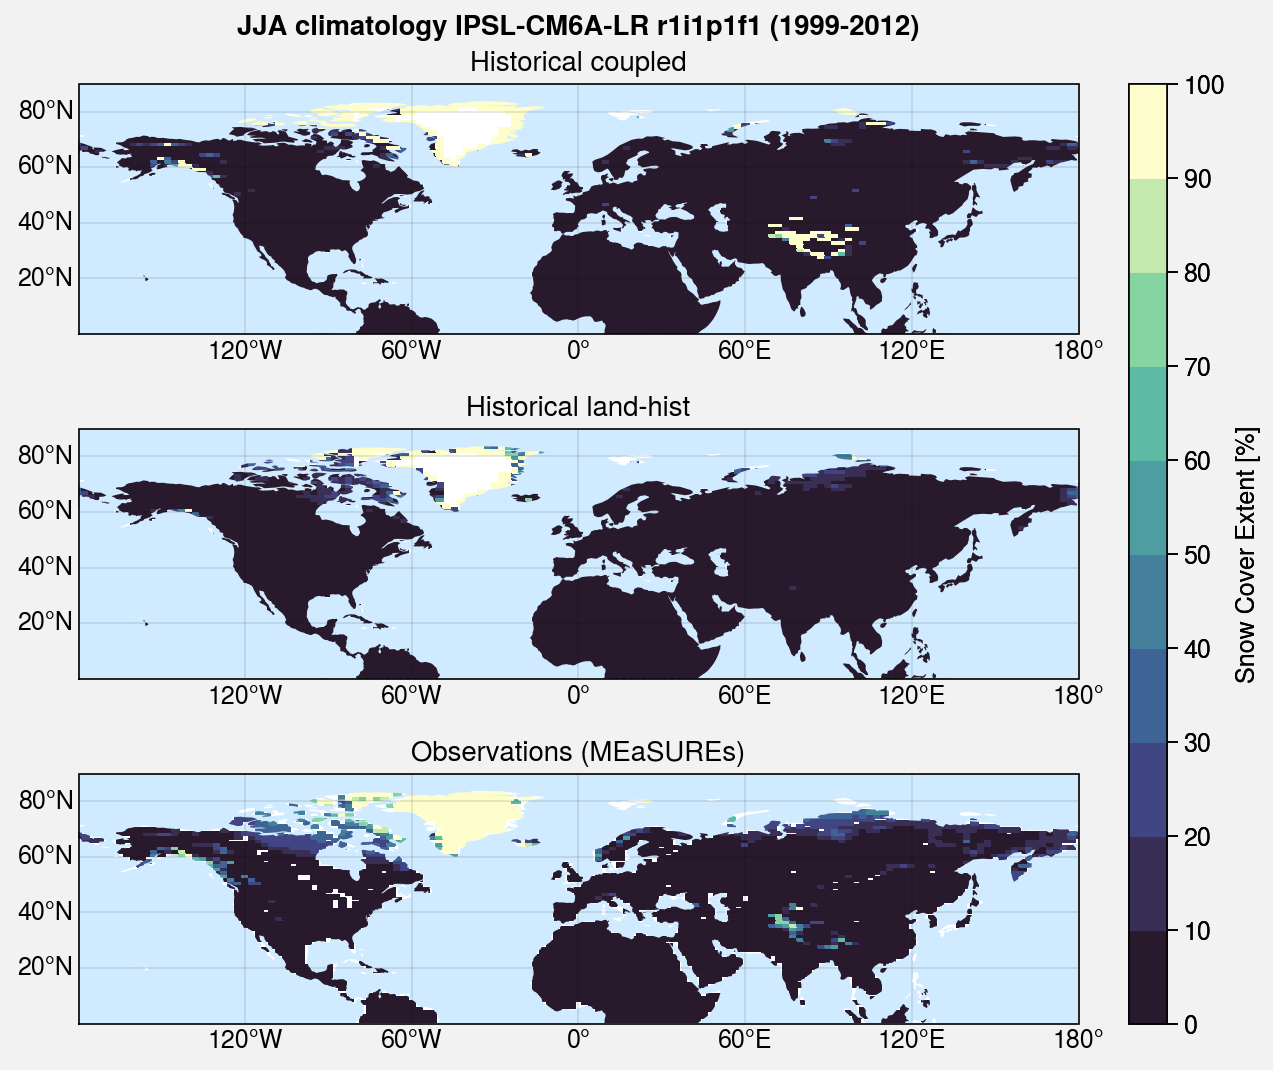

In [15]:
for i, season in enumerate(seasons):    
    fig, axs = plot.subplots(nrows=3, ncols=1, proj='cyl', axwidth=5)

    cmap='deep_r'
    levels=plot.arange(0,100,10)

    axs.format(
        labels=True,
        latlim=(0,90),
        ocean=True, oceancolor='blue1',
        coast=False,
        suptitle=season+' climatology '+model+' '+realization+' ('+period.start+'-'+period.stop+')'
    )

    axs[0].pcolormesh(clim_historical[i], cmap=cmap, levels=levels)
    axs[0].format(title='Historical coupled')

    axs[1].pcolormesh(clim_land_hist[i], cmap=cmap, levels=levels)
    axs[1].format(title='Historical land-hist')

    m = axs[2].pcolormesh(clim_obs_regrid[i], cmap=cmap, levels=levels)
    axs[2].format(title='Observations ('+obs.short_name+')')

    fig.colorbar(m, label=label+' ['+units+']')
    
    filename = season+'_'+var+'_clim_MEaSUREs_'+model+'_'+realization+'_LS3MIP_'+period.start+'-'+period.stop
    fig.save('img/IPSL/'+filename+'.jpg'), fig.save('img/IPSL/'+filename+'.png'), fig.save('img/IPSL/'+filename+'.pdf')

## Bias

In [16]:
bias_historical = [None]*len(seasons)
bias_land_hist = [None]*len(seasons)

for i, season in enumerate(seasons):
    bias_historical[i] = clim_historical[i] - clim_obs_regrid[i]
    bias_land_hist[i] = clim_land_hist[i] - clim_obs_regrid[i]

In [17]:
for i, season in enumerate(seasons):
    print(xr.ufuncs.fabs(bias_historical[i]).max().values, xr.ufuncs.fabs(bias_land_hist[i]).max().values)

98.29181835936134 82.64370301975305
99.023578565666 98.5442370686759
99.95420346667927 95.7251206039211


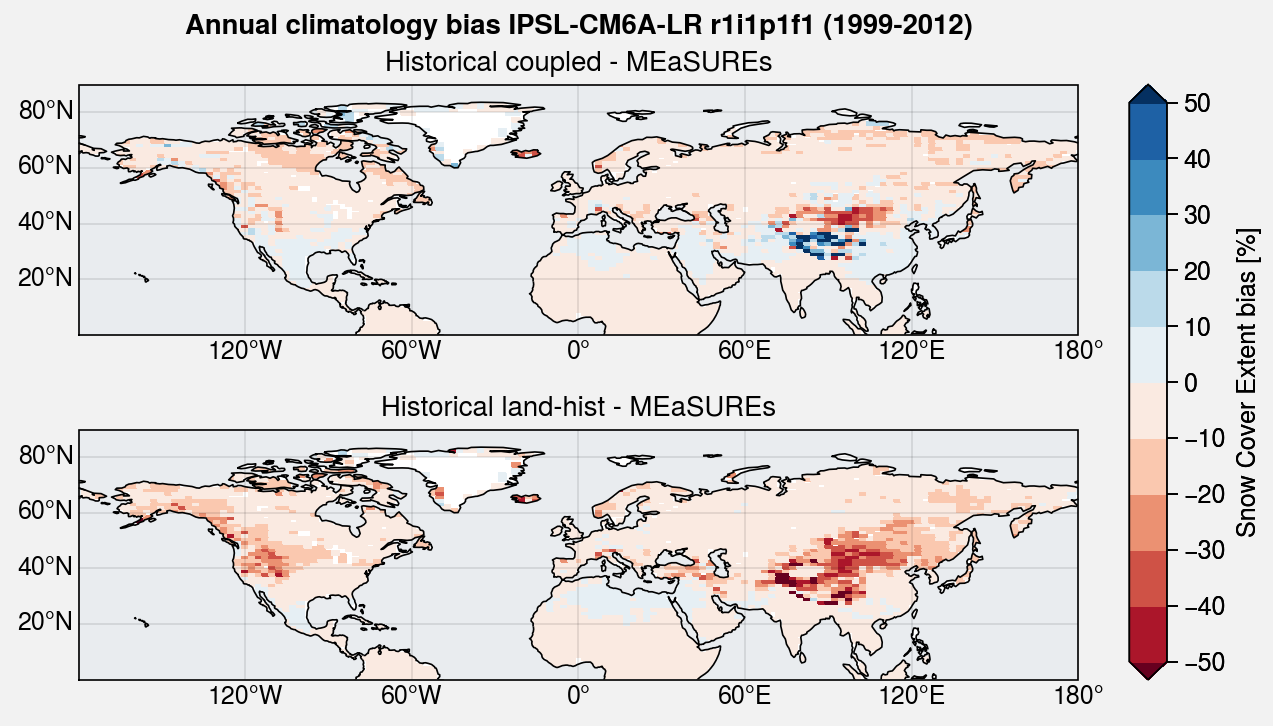

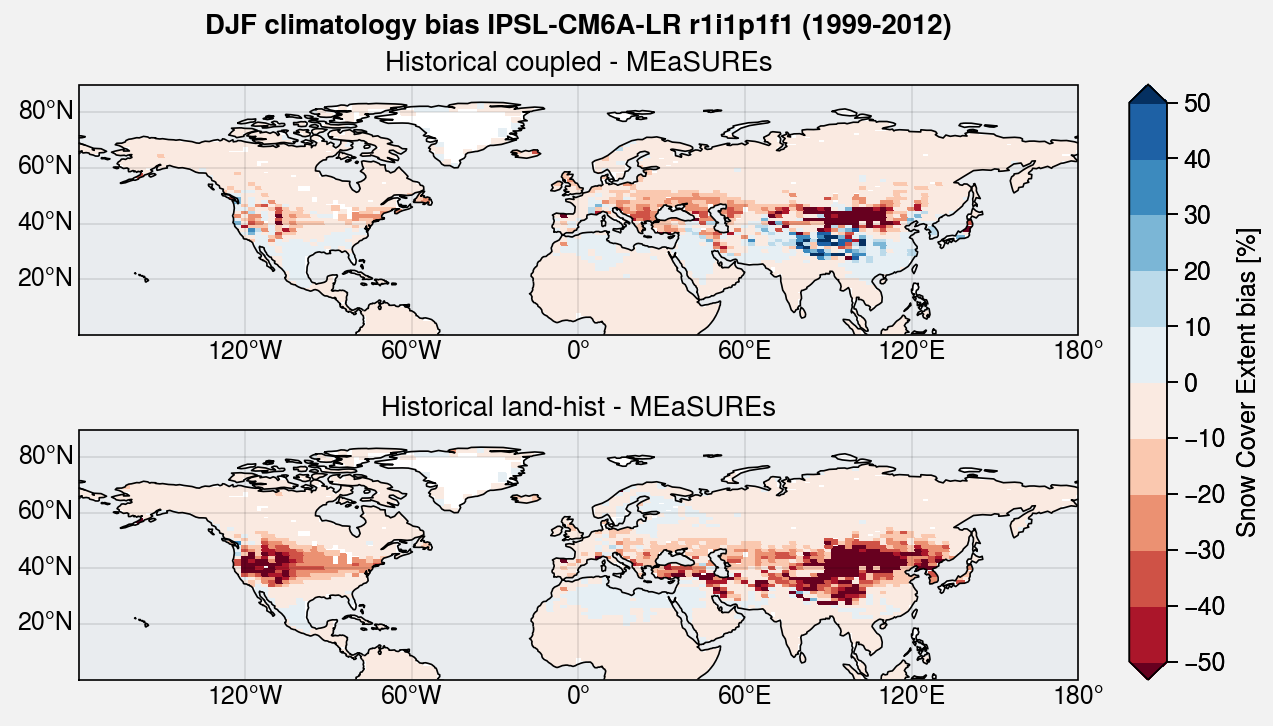

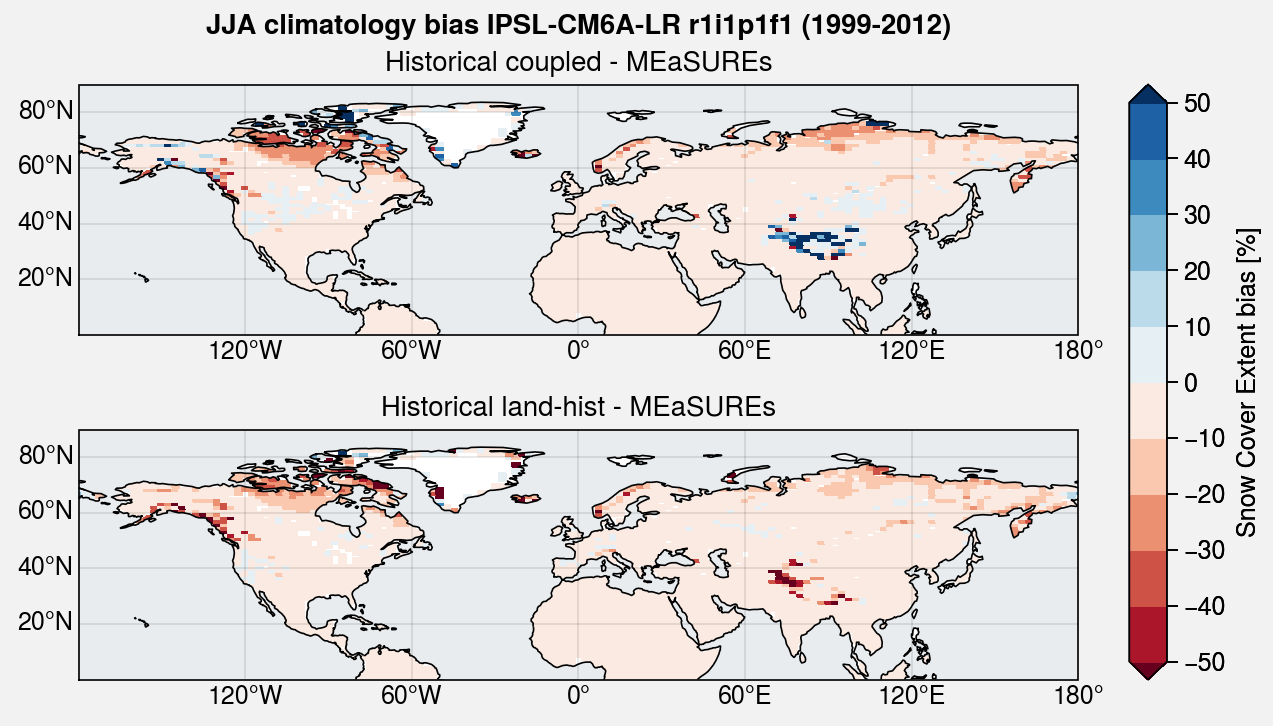

In [18]:
for i, season in enumerate(seasons):   
# for i, season in enumerate(['Annual']):   
    fig, axs = plot.subplots(nrows=2, ncols=1, proj='cyl', axwidth=5)

    cmap='RdBu'
    levels=plot.arange(-50,50,10)
    extend='both'

    axs.format(
        labels=True,
        latlim=(0,90),
        ocean=True, oceancolor='gray2',
        coast=True, borders=False,
        suptitle=season+' climatology bias '+model+' '+realization+' ('+period.start+'-'+period.stop+')'
    )

    axs[0].pcolormesh(bias_historical[i], cmap=cmap, levels=levels, extend=extend)
    axs[0].format(title='Historical coupled - '+obs.short_name)

    m = axs[1].pcolormesh(bias_land_hist[i], cmap=cmap, levels=levels, extend=extend)
    axs[1].format(title='Historical land-hist - '+obs.short_name)

    fig.colorbar(m, label=label+' bias ['+units+']')

    filename = season+'_'+var+'_bias_MEaSUREs_'+model+'_'+realization+'_LS3MIP_'+period.start+'-'+period.stop
    fig.save('img/IPSL/'+filename+'.jpg'), fig.save('img/IPSL/'+filename+'.png'), fig.save('img/IPSL/'+filename+'.pdf')